In [1]:
import pandas as pd

In [2]:
import state_utils

state_utils.set_cohort("Poyet")
state_utils.set_host("ao")
state_utils.set_midas_db_type("standard")

import config

In [3]:
import tslearn
from tslearn import clustering
from tslearn.generators import random_walks
from tslearn import metrics
from tslearn.metrics import cdist_dtw
from sklearn import metrics
from sklearn.cluster import KMeans

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
import fastcluster
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram,inconsistent,maxRstat
from sklearn import metrics
from sklearn.metrics import silhouette_score
import parse_patric
import parse_midas_data


In [20]:
species = "Bacteroides_ovatus_58035"
genome_ids=parse_midas_data.get_ref_genome_ids(species)
kegg=parse_patric.load_kegg_annotations(genome_ids)
base_dir = "/u/scratch/r/rwolff/Poyet_midas_output/merged_midas_output/ao_standard/genes/%s" % species
dates = config.dates

In [21]:
df = pd.read_csv("%s/genes_copynum.txt.bz2" % base_dir,index_col=0,sep="\t")

In [22]:
to_drop_rows = df.loc[(df.T == 0).all()].index

In [23]:
to_drop_cols = df.loc[:,(df == 0).all()].columns

In [24]:
df = df.drop(to_drop_rows)
df = df.drop(to_drop_cols,axis=1)


In [25]:
df = df.where(df > .05,0)
df = df.where(df < .05, 1)
to_drop_rows = df.loc[(df.T == 0).all()].index
to_drop_cols = df.loc[:,(df == 0).all()].columns
df = df.drop(to_drop_rows)
df = df.drop(to_drop_cols,axis=1)

#df = df.where(df < .5, 1)
#df = df.where(df > .5, 0)

In [26]:
df  = df[dates.loc[df.columns].sort_values().index]

In [ ]:
varrs = df.T.var().sort_values(ascending=False)
change_genes = varrs.iloc[:int(df.shape[0]*.1)].index
non_change_genes = varrs.iloc[int(df.shape[0]*.5):].index

In [ ]:
df_corr = df.corr()

df_corr_val = df_corr.values

In [ ]:
for i in range(df_corr_val.shape[0] - 1):
    for j in range(i,df_corr_val.shape[0]):
        df_corr_val[j][i] = df_corr_val[i][j]

In [ ]:
df_corr = pd.DataFrame(df_corr_val,index=df_corr.index,columns=df_corr.columns)

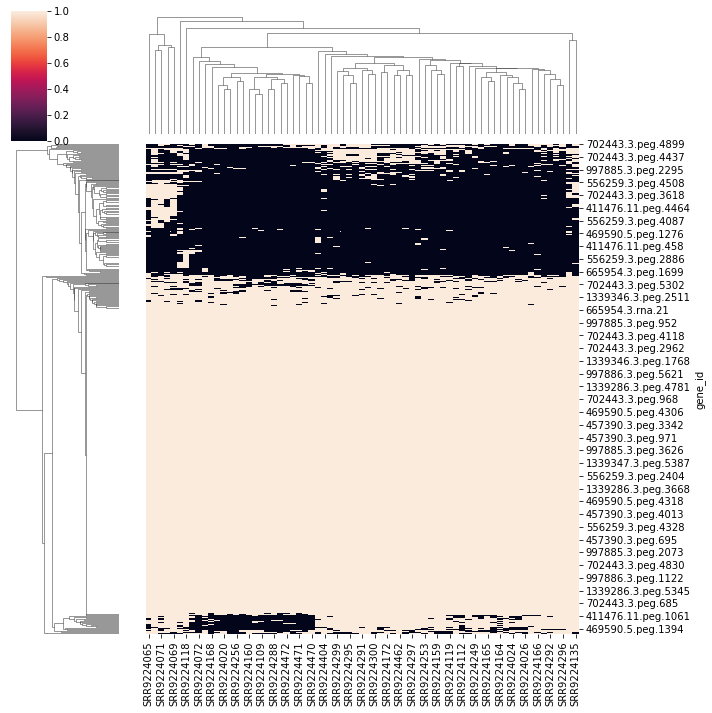

In [27]:
DF = df.sample(500)
C=sns.clustermap(DF);

In [ ]:
silhouette_scores = []
num_clusterss = range(2,10)
for num_clusters in num_clusterss:
            
    #MR = maxRstat(Z, inconsistent(Z), 3)
    nodes = fcluster(C.dendrogram_col.linkage, int(num_clusters), criterion="maxclust")
            
    #nodes = fcluster(Z, int(num_clusters), monocrit=MR, criterion="maxclust_monocrit")
    num_realized_clusters = len(set(nodes))
            
    if num_realized_clusters==1:
        S = 0
    else:
        S = metrics.silhouette_score(DF.values, nodes)
            
    silhouette_scores.append(S)
    
    print(num_clusters, num_realized_clusters, S)

In [ ]:
nodes = fcluster(C.dendrogram_col.linkage, 3.2, criterion="distance")
nodes

In [ ]:
change_genes = DF.loc[nodes==2].index

In [ ]:
scores_dic = {}
sample_scores_dic = {}
for i in range(2,10):
    km = clustering.TimeSeriesKMeans(n_clusters=i).fit(df.values)
    X = km.fit_predict(df.values)
    
    score = clustering.silhouette_score(df.values,X,metric="euclidean")
    scores_dic[i] = score
    print(i,score)

In [ ]:
clus_pick = pd.Series(scores_dic).idxmax()

In [ ]:
km = clustering.TimeSeriesKMeans(n_clusters=clus_pick).fit(df.values)

In [ ]:
X = km.fit_predict(df.values)


In [ ]:
np.unique(X,return_counts=True)

In [ ]:
non_change_genes = df.iloc[X==0].index
non_change_genes

In [ ]:
change_genes = df.iloc[X==1].index
change_genes

In [ ]:
change_genes_2 = df.iloc[X==2].index
change_genes_2

In [ ]:
change_gene_descriptions=parse_patric.load_patric_gene_descriptions(genome_ids, change_genes)

In [ ]:
non_change_gene_descriptions=parse_patric.load_patric_gene_descriptions(genome_ids, non_change_genes)

In [ ]:
change_gene_categories, change_gene_category_map = parse_patric.cluster_patric_gene_descriptions(change_gene_descriptions)

In [ ]:
non_change_gene_categories,  non_change_gene_category_map = parse_patric.cluster_patric_gene_descriptions(non_change_gene_descriptions)

In [ ]:
pd.Series(change_gene_categories).sort_values(ascending=False)

In [ ]:
gene_type = "ABC-type antimicrobial peptide transport system, permease component"
mobs=pd.Series(change_gene_category_map).loc[pd.Series(change_gene_category_map) == gene_type].index

In [ ]:
(pd.Series(change_gene_categories)/pd.Series(non_change_gene_categories)).sort_values(ascending=False)[:40]

In [ ]:
df

In [ ]:
plt.scatter(df.T.var())

In [ ]:
plt.plot(df.T.mean().values)

In [ ]:
plt.plot(df_c.loc[mobs].T.values,color="grey",alpha=.7);
#plt.ylim([0,1])

In [ ]:
df_c = pd.read_csv("%s/genes_copynum.txt.bz2" % base_dir,index_col=0,sep="\t")

In [ ]:
fig,ax = plt.subplots(figsize=(12,8))
#ax.plot(df.loc[non_change_genes].T.values,color="grey",alpha=.007);
ax.plot(df_c.loc[change_genes].T.values,color="red",alpha=.07);
ax.set_ylabel("Gene copy number")
ax.set_xlabel("Time")
#ax.set_ylim([0,1])